## Malaria Detection using cells - CNN using Keras

Dataset Link : https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

### EDA

In [3]:
import os

data_dir = "cell_images/"
os.listdir(data_dir)

parasitized = os.listdir(data_dir+"Parasitized")
uninfected = os.listdir(data_dir+"Uninfected")

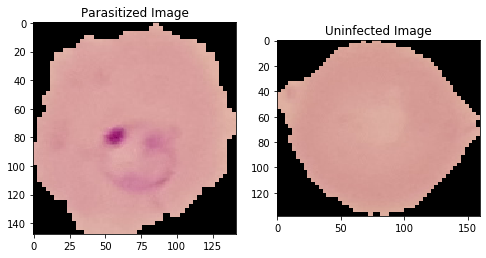

In [4]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].set_title("Parasitized Image")

imgp = cv2.imread(data_dir+"Parasitized/"+parasitized[0])
imgp = cv2.cvtColor(imgp, cv2.COLOR_BGR2RGB)
ax[0].imshow(imgp)

imgu = cv2.imread(data_dir+"Uninfected/"+uninfected[0])
imgu = cv2.cvtColor(imgu, cv2.COLOR_BGR2RGB)
ax[1].set_title("Uninfected Image")
ax[1].imshow(imgu)
plt.show()

In [5]:
x = []
y = []

for img in parasitized:
    try:
        path = data_dir+"Parasitized/"+img
        cell = cv2.imread(path)
        x.append(cell.shape[0]) 
        y.append(cell.shape[1])
    except:
        continue
    
for img in uninfected:
    try:
        path = data_dir+"Uninfected/"+img
        cell = cv2.imread(path)
        x.append(cell.shape[0])
        y.append(cell.shape[1])
    except:
        continue

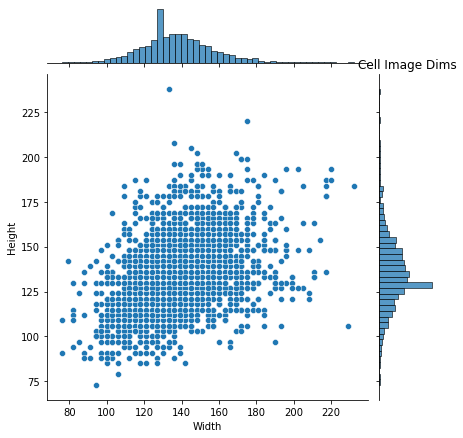

In [6]:
sns.jointplot(x=x,y=y).set_axis_labels("Width", "Height")
plt.title("Cell Image Dims")
plt.show()

In [7]:
print("X Dim Mean :", np.mean(x))
print("Y Dim Mean :", np.mean(y))

X Dim Mean : 138.0792792792793
Y Dim Mean : 135.37657657657658


### Augmentation

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               rescale=1/255,
                               validation_split=0.3)

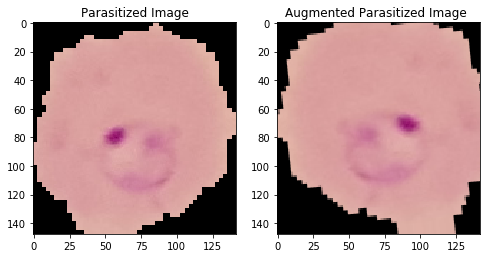

In [9]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].set_title("Parasitized Image")

img1 = cv2.imread(data_dir+"Parasitized/"+parasitized[0])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
ax[0].imshow(img1)

ax[1].set_title("Augmented Parasitized Image ")
ax[1].imshow(image_gen.random_transform(img1))
plt.show()

###   

### CNN Model

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout

model = Sequential()

model.add( Conv2D(filters=32, kernel_size=(3,3), input_shape=(135,135,3), activation="relu") )
model.add( MaxPool2D(pool_size=(2,2)) )

model.add( Conv2D(filters=64, kernel_size=(3,3), input_shape=(135,135,3), activation="relu") )
model.add( MaxPool2D(pool_size=(2,2)) )

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation="sigmoid"))


model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 133, 133, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 66, 66, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_loss", patience=1)

In [33]:
batch_size = 512

train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(135,135), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          subset="training")


test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(135,135), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          shuffle=False,
                                          subset="validation")

test_image_gen.class_indices

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

In [34]:
predictions = model.fit(train_image_gen, epochs=20, 
                                  validation_data = test_image_gen,
                                  callbacks=[early_stop])

Epoch 1/20
38/38 [==============================] - 121s 3s/step - loss: 0.6117 - accuracy: 0.6884 - val_loss: 0.5203 - val_accuracy: 0.7782
Epoch 2/20
38/38 [==============================] - 118s 3s/step - loss: 0.4844 - accuracy: 0.7973 - val_loss: 0.3937 - val_accuracy: 0.8478
Epoch 3/20
38/38 [==============================] - 118s 3s/step - loss: 0.3802 - accuracy: 0.8582 - val_loss: 0.3100 - val_accuracy: 0.8845
Epoch 4/20
38/38 [==============================] - 118s 3s/step - loss: 0.3121 - accuracy: 0.8883 - val_loss: 0.2546 - val_accuracy: 0.8987
Epoch 5/20
38/38 [==============================] - 117s 3s/step - loss: 0.2831 - accuracy: 0.8998 - val_loss: 0.2408 - val_accuracy: 0.9089
Epoch 6/20
38/38 [==============================] - 117s 3s/step - loss: 0.2582 - accuracy: 0.9100 - val_loss: 0.2258 - val_accuracy: 0.9145
Epoch 7/20
38/38 [==============================] - 117s 3s/step - loss: 0.2503 - accuracy: 0.9115 - val_loss: 0.2247 - val_accuracy: 0.9107
Epoch 8/20
38

### Model Evaluation

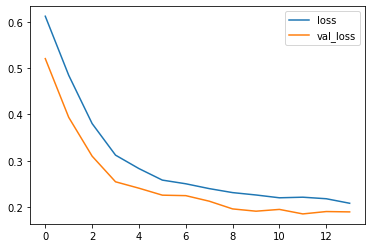

In [35]:
metrics = pd.DataFrame(model.history.history)
metrics[["loss","val_loss"]].plot()

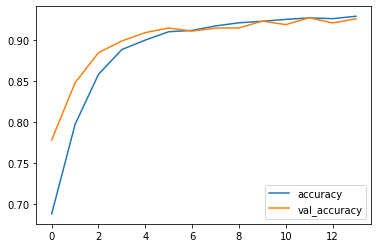

In [36]:
metrics[["accuracy","val_accuracy"]].plot()

In [45]:
model.save("cells.h5")

### Evaluation

In [50]:
test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=(135,135), 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='binary',
                                          shuffle=False,
                                          subset="validation")

Found 8266 images belonging to 2 classes.


In [51]:
results = model.evaluate(test_image_gen)

print("Loss : ",results[0])
print("Accuracy : ",results[1]*100,"%")

17/17 [==============================] - 35s 2s/step - loss: 0.1901 - accuracy: 0.9260
Loss :  0.19006308913230896
Accuracy :  92.59617924690247 %


In [52]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_image_gen)

In [43]:
predictions>0.5

array([[ True],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

In [53]:
predictions = predictions>0.5
print(classification_report(test_image_gen.classes, predictions))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      4133
           1       0.96      0.89      0.92      4133

    accuracy                           0.93      8266
   macro avg       0.93      0.93      0.93      8266
weighted avg       0.93      0.93      0.93      8266



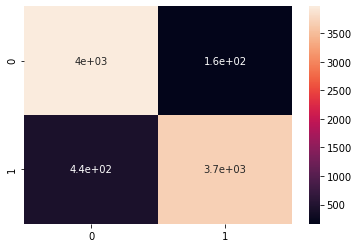

In [54]:
mat = confusion_matrix(test_image_gen.classes, predictions)
sns.heatmap(mat, annot=True)
plt.show()

### Predict single cell

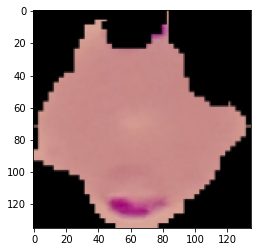

In [68]:
img = cv2.imread(data_dir+"Parasitized/"+parasitized[105])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (135, 135))
img = img/255
plt.imshow(img)
plt.show()

In [69]:
# dim = (batchsize, x(width), y(height), color_channels)

img = np.expand_dims(img, axis=0)
img.shape

(1, 135, 135, 3)

In [70]:
res = model.predict(img)
res

array([[0.0785513]], dtype=float32)

In [71]:
train_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}